In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.signal import savgol_filter
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [37]:
#
#
# There are two derivatives functions, one for noise and one for 0 noise.  
# 
#

def raw_spectra(df, noise_std):
    '''
    Applies and smooths noise to averaged spectra.
    '''
    X = df.drop(labels=['CN', 'Num Cu', 'Num Te'], axis=1)
    list = X.columns.tolist()

    X.columns = range(X.shape[1])

    noise = np.random.normal(0, noise_std, [10000,1000])
    X_noise = X + noise
    X_noise.columns = list
    for index, row in X_noise.iterrows():
        X_noise.loc[index] = savgol_filter(row, 101, 3)

    for index, row in X_noise.iterrows():
        X_noise.loc[index] = savgol_filter(row, 51, 2)  

    if noise_std == 0:
        features = X
    else:
        features=X_noise

    return features

def derivatives_zero_noise(mu_df, dx=0.80808080808):
    '''
    Calculates and returns the first and second derivative of the spectra - only used when there is zero noise.
    '''

    dmu1 = np.zeros([len(mu_df), len(mu_df.columns)-1])
    dmu2 = np.zeros([len(mu_df), len(mu_df.columns)-2])

    if len(mu_df.columns) == 1000:
        dx =0.1*dx

    for i in range(len(mu_df)):
        for j in range(len(mu_df.columns)-1):
            dmu1[i, j] = (mu_df.iloc[i, j+1] - mu_df.iloc[i, j]) / dx

    for i_ in range(len(mu_df)):
        for j_ in range(len(mu_df.columns)-2):
            dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx
    
    dmu1_2 = np.concatenate([dmu1, dmu2], axis=1)       

    return dmu1, dmu2, dmu1_2

def derivatives_noise(features, dx=0.80808080808):
    '''
    raw_spectra applies noise and smooths the spectra then returns the smoothed spectra 'features', this functions uses 
    the smoothed spectra to calculate the first derivative, smooth the first derivative, then calculate the second derivative.
    It returns the smoothed first derivative and the calculated second derivative.
    '''
    
    dmu1 = np.zeros([len(features), len(features.columns)-1])
    dmu2 = np.zeros([len(features), len(features.columns)-2])
    
    if len(features.columns) == 1000:
        dx =0.1*dx

    for i in range(len(features)):
        for j in range(len(features.columns)-1):
            dmu1[i, j] = (features.iloc[i, j+1] - features.iloc[i, j]) / dx
    
    dmu1 = pd.DataFrame(dmu1)
    for index, row in dmu1.iterrows():
        dmu1.loc[index, :] = savgol_filter(row, 51,2)
    dmu1 = np.asarray(dmu1)

    for i_ in range(len(features)):
        for j_ in range(len(features.columns)-2):
            dmu2[i_, j_] = (dmu1[i_, j_+1] - dmu1[i_, j_]) / dx
            
    dmu1_2 = np.concatenate([dmu1, dmu2], axis=1)

    return dmu1, dmu2, dm1_2    

#
# Run train layer to train multiple epochs, find the best epoch will then train using the best epoch 
# analyse_layer will then return loss data, append_data_to_list then stores the loss data 
# and finally plot_data will plot parity plots for each feature. run_layer calls all these functions 
#

def train_layer(X_train, y_train):
    '''
    train_layer trains the neural network. One layer is added, and the depth of the that layer is optimized by 
    looking at the loss from a range of 1 to 100, the maximum number of features being trained on.
    '''
    
    loss = []
    for i in range(100):
        if i == 0:
            pass
        else:
            nn = MLPRegressor(hidden_layer_sizes=(i), activation='identity', solver='lbfgs', max_iter=2000, 
                              random_state=28)
            nn = nn.fit(X_train, y_train)
            loss.append(nn.loss_)

    lossdf = pd.DataFrame(loss)
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        print(lossdf)
    return lossdf

def find_best_epoch(lossdf, X_train, y_train):
    '''
    find_best_epoch is a function to return the epoch with the lowest loss, and the loss value
    '''
    
    min_loss = lossdf.idxmin()[0]+1
    print(min_loss)
    best_nn = MLPRegressor(hidden_layer_sizes=(min_loss), activation='identity', solver='lbfgs', max_iter=2000, 
                           random_state=28)
    best_nn = best_nn.fit(X_train, y_train)
    loss = best_nn.loss_
    print(loss)
    
    return min_loss, loss, best_nn

def analyse_layer(X_train, X_test, y_train, y_test, best_nn):
    '''
    analyse_layer returns the training mse and r2 values for the layer in the neural network
    '''
    
    y_train_pred = best_nn.predict(X_train)
    y_test_pred = best_nn.predict(X_test)
    train_score_CN = r2_score(y_train.iloc[:,0], y_train_pred[:,0])
    train_score_Cu = r2_score(y_train.iloc[:,1], y_train_pred[:,1]) 
    train_score_Te = r2_score(y_train.iloc[:,2], y_train_pred[:,2])
    test_score_CN = r2_score(y_test.iloc[:,0], y_test_pred[:,0])
    test_score_Cu = r2_score(y_test.iloc[:,1], y_test_pred[:,1])
    test_score_Te = r2_score(y_test.iloc[:,2], y_test_pred[:,2])
    train_mse_CN = mean_squared_error(y_train.iloc[:,0], y_train_pred[:,0])
    train_mse_Cu = mean_squared_error(y_train.iloc[:,1], y_train_pred[:,1])
    train_mse_Te = mean_squared_error(y_train.iloc[:,2], y_train_pred[:,2])
    test_mse_CN = mean_squared_error(y_test.iloc[:,0], y_test_pred[:,0])
    test_mse_Cu = mean_squared_error(y_test.iloc[:,1], y_test_pred[:,1])
    test_mse_Te = mean_squared_error(y_test.iloc[:,2], y_test_pred[:,2])

    train_score_list = [train_score_CN, train_score_Cu, train_score_Te]
    train_mse_list = [train_mse_CN, train_mse_Cu, train_mse_Te]
    test_mse_list = [test_mse_CN, train_mse_Cu, train_mse_Te]
    test_score_list = [test_score_CN, test_score_Cu, test_score_Te]
    print('training mse =  '+ str(train_mse_list))
    print('testing mse = ' + str(test_mse_list))
    print('training R2 = ' + str(train_score_list))
    print('testing R2 = ' + str(test_score_list))
    
    return test_mse_list, test_score_list, y_test_pred

def append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                         score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    append_layer_to_list takes the mse and score lists and appends them to a list for plotting erros vs noise, 
    note that here mse is converted to rmse
    '''
    
    rmse_CN = np.sqrt(test_mse_list[0])
    rmse_CN_i_list.append(rmse_CN)
    rmse_Cu = np.sqrt(test_mse_list[1])
    rmse_Cu_i_list.append(rmse_Cu)
    rmse_Te = np.sqrt(test_mse_list[2])
    rmse_Te_i_list.append(rmse_Te)
    
    score_CN = test_score_list[0]
    score_CN_i_list.append(score_CN)
    score_Cu = test_score_list[1]
    score_Cu_i_list.append(score_Cu)
    score_Te = test_score_list[2]
    score_Te_i_list.append(score_Te)

def plot_layer(y_test, y_test_pred):
    '''
    plot_layer is a function to generate parity plots for the layer to check performance for predicting 
    coordination number, number of nearest Te atoms, and number of nearest Cu atoms.
    '''
    x1 = np.linspace(8, 12, 50)
    x2 = np.linspace(4, 8, 50)
    x3 = np.linspace(4, 5, 50)

    plt.figure(figsize=[14,4])
    plt.subplots_adjust(wspace=0.3)
    ax1 = plt.subplot(1,3,1)
    ax1.scatter(y_test.iloc[:,0], y_test_pred[:,0])
    ax1.plot(x1, x1, color='red')
    ax1.set_xlabel('True CN')
    ax1.set_ylabel('Pred CN')
    ax1.set_title('Test CN')
    plt.axis('equal')

    ax2 = plt.subplot(1,3,2)
    ax2.scatter(y_test.iloc[:,1], y_test_pred[:,1])
    ax2.plot(x2, x2, color='red')
    ax2.set_xlabel('True Cu Num')
    ax2.set_ylabel('Pred Cu Num')
    ax2.set_title('Test Cu Num')
    plt.axis('equal')


    ax3 = plt.subplot(1,3,3)
    ax3.scatter(y_test.iloc[:,2], y_test_pred[:,2])
    ax3.plot(x3, x3, color='red')
    ax3.set_xlabel('True Te Num')
    ax3.set_ylabel('Pred Te Num')
    ax3.set_title('Test Te Num')
    plt.axis('equal')
    
    
def run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
              score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    run_layer is a wrapper function that executes the training, testing, analysis, and plotting for a 
    single layer of the neural network
    '''
    lossdf = train_layer(X_train, y_train)
    min_loss, loss, best_nn  = find_best_epoch(lossdf, X_train, y_train)
    test_mse_list, test_score_list, y_test_pred = analyse_layer(X_train, X_test, y_train, y_test, best_nn)
    append_layer_to_list(test_mse_list, test_score_list, rmse_CN_i_list, score_CN_i_list, 
                         rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    plot_layer(y_test, y_test_pred)

#
#  MLP_per_noise functions will itterate through each noise value and return the results
#  There is a unique function for spectrum, first derivative, second derivative, and
#  both derivatives combined
#

def MLP_per_noise_spectra(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                          score_Cu_i_list, rmse_Te_i_list, score_Te_i_list):
    '''
    MLP_per_noise is a wrapper function that runs a layer of neural network per level of noise
    '''
    for entry in Noise_STD:
        print('noise_std: ' + entry)
        X = raw_spectra(df, entry)
        y = df[['CN', 'Num Cu', 'Num Te']]
        X_train, X_test, y_train, y_test = train_test_split(df, y)
        run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, 
                  score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

    print(rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)
    return rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list

def MLP_per_noise_1(df, Noise_STD, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, 
                    rmse_Te_i_list_1, score_Te_i_list_1):
    for entry in Noise_STD:
        if entry == 0:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df1, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, 
                      score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1)
        else: 
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df1, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, 
                      score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1)
        

    print(rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, 
                    score_Te_i_list_1)
    return rmse_CN_i_list_1, score_CN_i_list_1, rmse_Cu_i_list_1, score_Cu_i_list_1, rmse_Te_i_list_1, score_Te_i_list_1
    
def MLP_per_noise_2(df, Noise_STD, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, 
                    rmse_Te_i_list_2, score_Te_i_list_2):
    for entry in Noise_STD:
        if entry == 0:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df2, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, 
                  score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2)
        else:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df2, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, 
                      score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2)
    
    
    print(rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, 
            score_Te_i_list_2)
    return rmse_CN_i_list_2, score_CN_i_list_2, rmse_Cu_i_list_2, score_Cu_i_list_2, rmse_Te_i_list_2, score_Te_i_list_2
    
def MLP_per_noise_1_2(df, Noise_STD, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                      score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2):
    for entry in Noise_STD:
        if entry == 0:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_zero_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df3, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                      score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2)
        else:
            X = raw_spectra(df, entry)
            y = df[['CN', 'Num Cu', 'Num Te']]
            df1, df2, df3 = derivatives_noise(X)
            X_train, X_test, y_train, y_test = train_test_split(df3, y)
            run_layer(X_train, X_test, y_train, y_test, rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, 
                      score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2)
    

    print(rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, 
            score_Te_i_list_1_2)
    return rmse_CN_i_list_1_2, score_CN_i_list_1_2, rmse_Cu_i_list_1_2, score_Cu_i_list_1_2, rmse_Te_i_list_1_2, score_Te_i_list_1_2
    

# 
# The following functions deal with iterating through each noise multiple times and averaging them   
# compile_score_lists functions itterate and store lists of loss data
# average_scores functions take the average of each noise level 
# There is a unique set of average_scores and compile_score_lists for the spectrum, the first derivative, 
# the decond derivative, and both derivatives combined
#

def average_scores_spectra(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_spectra(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_spectra = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_spectra
    
def compile_score_lists_spectra(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_spectra(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1
    
def compile_score_lists_1(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_1(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_2
    
def compile_score_lists_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_2(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

def average_scores_1_2(iterations, df, Noise_STD):
    '''
    average_error generates a dataframe for each set of scores, averages all the scores from multiple 
    itterations, and returns the average values as series for each set of scores
    
    '''

    rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list = compile_score_lists_1_2(iterations, df, Noise_STD)

    #generate dataframes for each set of scores
    rmse_CN_master_df = pd.DataFrame(rmse_CN_master_list, columns = Noise_STD)
#    print('rmse_CN_master_df')
#    print(rmse_CN_master_df)
    score_CN_master_df = pd.DataFrame(score_CN_master_list, columns = Noise_STD)
#    print('score_CN_master_df')
#    print(score_CN_master_df)
    rmse_Cu_master_df = pd.DataFrame(rmse_Cu_master_list, columns = Noise_STD)
#    print('rmse_Cu_master_df')
#    print(rmse_Cu_master_df)
    score_Cu_master_df = pd.DataFrame(score_Cu_master_list, columns = Noise_STD)
#    print('score_Cu_master_df')
#    print(score_Cu_master_df)
    rmse_Te_master_df = pd.DataFrame(rmse_Te_master_list, columns = Noise_STD)
#    print('rmse_Te_master_df')
#    print(rmse_Te_master_df)
    score_Te_master_df = pd.DataFrame(score_Te_master_list, columns = Noise_STD)
#    print('score_Te_master_df')
#    print(score_Te_master_df)


    #average the data in the dataframes
    average_rmse_CN = rmse_CN_master_df.mean(axis=0)
    average_rmse_CN = average_rmse_CN.rename('rmse_CN')
    average_score_CN = score_CN_master_df.mean(axis=0)
    average_score_CN = average_score_CN.rename('r2_CN')
    average_rmse_Cu = rmse_Cu_master_df.mean(axis=0)
    average_rmse_Cu = average_rmse_Cu.rename('rmse_Cu')
    average_score_Cu = score_Cu_master_df.mean(axis=0)
    average_score_Cu = average_score_Cu.rename('r2_Cu')
    average_rmse_Te = rmse_Te_master_df.mean(axis=0)
    average_rmse_Te = average_rmse_Te.rename('rmse_Te')
    average_score_Te = score_Te_master_df.mean(axis=0)
    average_score_Te = average_score_Te.rename('r2_Te')

    results_df_1_2 = pd.concat([average_rmse_CN, average_score_CN, average_rmse_Cu, average_score_Cu, 
                            average_rmse_Te, average_score_Te], axis=1)
    return results_df_1_2
    
def compile_score_lists_1_2(iterations, df, Noise_STD):
    '''
    average_MLP_models itterates through multiple expieriments and compile a masterlist 
    of all data
    '''
    rmse_CN_master_list = []
    score_CN_master_list = []
    rmse_Cu_master_list = []
    score_Cu_master_list = []
    rmse_Te_master_list = []
    score_Te_master_list = []
    
    for i in range(iterations):
        rmse_CN_i_list = []
        score_CN_i_list = []
        rmse_Cu_i_list = []
        score_Cu_i_list = []
        rmse_Te_i_list = []
        score_Te_i_list = []
        
        rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list = MLP_per_noise_1_2(df, Noise_STD, rmse_CN_i_list, score_CN_i_list, rmse_Cu_i_list, score_Cu_i_list, rmse_Te_i_list, score_Te_i_list)

        rmse_CN_master_list.append(rmse_CN_i_list)
        score_CN_master_list.append(score_CN_i_list)
        rmse_Cu_master_list.append(rmse_Cu_i_list)
        score_Cu_master_list.append(score_Cu_i_list)
        rmse_Te_master_list.append(rmse_Te_i_list)
        score_Te_master_list.append(score_Te_i_list)
        
    return rmse_CN_master_list, score_CN_master_list, rmse_Cu_master_list, score_Cu_master_list, rmse_Te_master_list, score_Te_master_list 

    

Data import of 10,000 calculated average XANES spectra along with averaged coordination numbers, number of Cu atoms within 3 angstroms, and number of Te atoms within 3 angstroms.

In [9]:
df = pd.read_csv('mu_cn1000_energies.csv')

# Train with Spectra Only:

Create dataframes for plotting noise vs R2 an RMSE

In [10]:
Noise_STD = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
iterations = 20

In [17]:
Noise_STD = [0, 0.005]
iterations = 2

           0
0   0.007626
1   0.000039
2   0.000029
3   0.000032
4   0.000053
5   0.000035
6   0.000011
7   0.000055
8   0.000024
9   0.000033
10  0.000041
11  0.000023
12  0.000029
13  0.000028
14  0.000044
15  0.000028
16  0.000018
17  0.000028
18  0.000031
19  0.000013
20  0.000027
21  0.000013
22  0.000045
23  0.000049
24  0.000035
25  0.000011
26  0.000036
27  0.000031
28  0.000040
29  0.000011
30  0.000011
31  0.000011
32  0.000031
33  0.000044
34  0.000049
35  0.000044
36  0.000033
37  0.000031
38  0.000014
39  0.000043
40  0.000045
41  0.000013
42  0.000033
43  0.000010
44  0.000025
45  0.000016
46  0.000015
47  0.000013
48  0.000026
49  0.000011
50  0.000028
51  0.000015
52  0.000052
53  0.000026
54  0.000041
55  0.000011
56  0.000031
57  0.000012
58  0.000013
59  0.000021
60  0.000012
61  0.000014
62  0.000031
63  0.000034
64  0.000023
65  0.000036
66  0.000028
67  0.000031
68  0.000020
69  0.000015
70  0.000034
71  0.000025
72  0.000013
73  0.000029
74  0.000029
75  0.000030

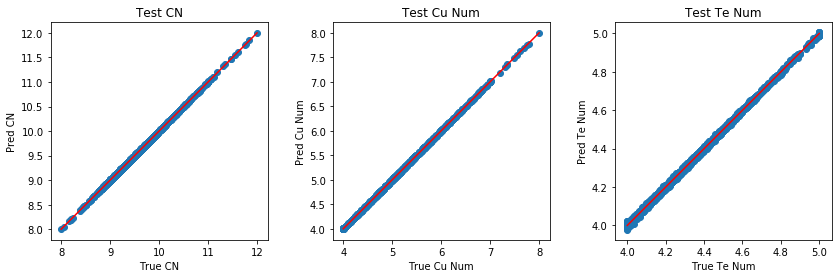

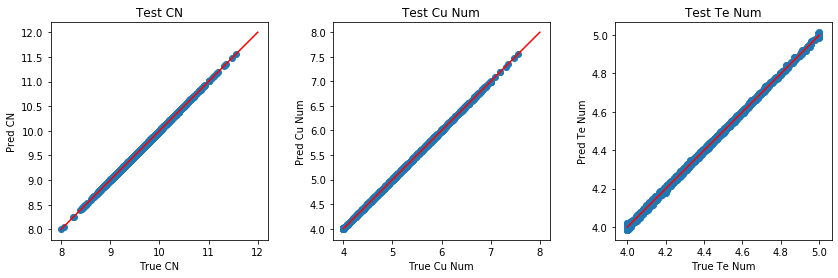

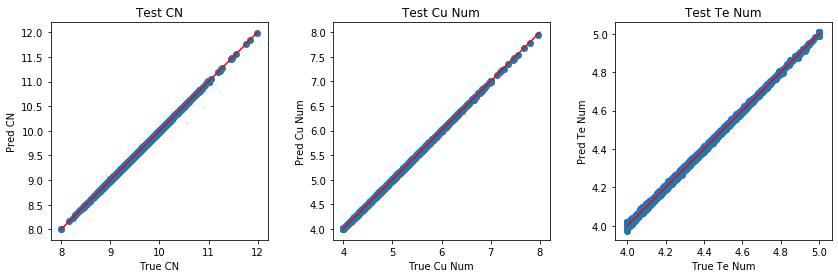

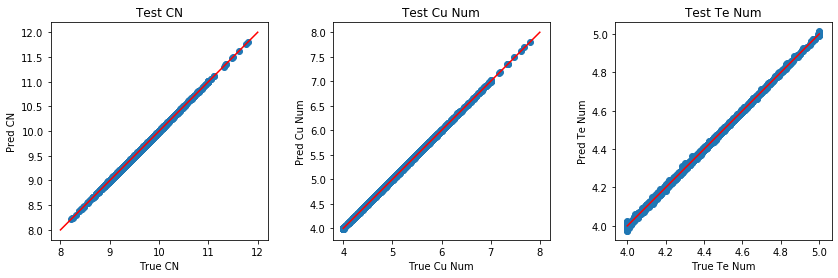

In [24]:
results_df_spectra = average_scores_spectra(iterations, df, Noise_STD)

# Train with first derivative:

           0
0   0.007544
1   0.000296
2   0.000271
3   0.000265
4   0.000303
5   0.000296
6   0.000307
7   0.000323
8   0.000300
9   0.000288
10  0.000281
11  0.000325
12  0.000293
13  0.000290
14  0.000307
15  0.000305
16  0.000286
17  0.000315
18  0.000282
19  0.000296
20  0.000351
21  0.000279
22  0.000372
23  0.000393
24  0.000320
25  0.000305
26  0.000321
27  0.000314
28  0.000383
29  0.000338
30  0.000370
31  0.000369
32  0.000383
33  0.000310
34  0.000365
35  0.000327
36  0.000355
37  0.000326
38  0.000342
39  0.000307
40  0.000442
41  0.000351
42  0.000316
43  0.000299
44  0.000335
45  0.000344
46  0.000403
47  0.000348
48  0.000360
49  0.000397
50  0.000333
51  0.000382
52  0.000323
53  0.000392
54  0.000332
55  0.000370
56  0.000342
57  0.000347
58  0.000343
59  0.000411
60  0.000387
61  0.000360
62  0.000371
63  0.000339
64  0.000388
65  0.000450
66  0.000339
67  0.000328
68  0.000328
69  0.000421
70  0.000371
71  0.000417
72  0.000346
73  0.000385
74  0.000358
75  0.000358

NameError: name 'dm1_2' is not defined

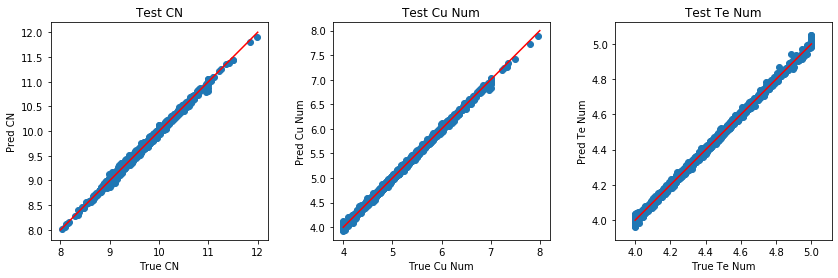

In [38]:
results_df_1 = average_scores_1(iterations, df, Noise_STD)

# Train with second derivative:

In [ ]:
results_df_2 = average_scores_2(iterations, df, Noise_STD)

# Train with both the first and second derivative:

In [ ]:
results_df_1_2 = average_scores_1_2(iterations, df, Noise_STD)

# Plot the error for predicting coordination number:

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_CN'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_CN'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_CN'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_CN'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise Standard Deviation', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_CN'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_CN'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_CN'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_CN'], c='green', lw=2.5)
ax2.set_xlabel('Noise Standard Deviation', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

# Plot the error for predicting number of nearest Cu:

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_Cu'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_Cu'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_Cu'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_Cu'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise Standard Deviation', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_Cu'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_Cu'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_Cu'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_Cu'], c='green', lw=2.5)
ax2.set_xlabel('Noise Standard Deviation', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()

# Plot the error for predicting number of nearest Te:

In [ ]:
plt.rcParams.update({'font.size': 14})
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,5])
plt.subplots_adjust(wspace=0.3)
ax1.plot(size_list, results_df_spectra['r2_Te'], c='blue', lw=2.5, label='Spectrum')
ax1.plot(size_list, results_df_1['r2_Te'], c='red', lw=2.5, label='First Derivative')
ax1.plot(size_list, results_df_2['r2_Te'], c='darkorange', lw=2.5, label='Second Derivative')
ax1.plot(size_list, results_df_1_2['r2_Te'], c='green', lw=2.5, label='Both Derivatives')
ax1.set_xlabel('Noise Standard Deviation', fontsize=16)
ax1.set_ylabel('$R^2$', fontsize=16)
ax2.plot(size_list, results_df_spectra['rmse_Te'], c='blue', lw=2.5)
ax2.plot(size_list, results_df_1['rmse_Te'], c='red', lw=2.5)
ax2.plot(size_list, results_df_2['rmse_Te'], c='darkorange', lw=2.5)
ax2.plot(size_list, results_df_1_2['rmse_Te'], c='green', lw=2.5)
ax2.set_xlabel('Noise Standard Deviation', fontsize=16)
ax2.set_ylabel('RMSE', fontsize=16)
ax1.legend()
plt.show()